In [28]:
import requests
import pandas as pd
import re
import numpy as np
import functools
import math
import numpy.random as n
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from numpy import array
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM,Dense,SimpleRNN,Input,Embedding,Bidirectional,Dropout,SpatialDropout1D
from tensorflow.keras.optimizers import RMSprop, Adam

In [29]:
def _get_sequences(texts,tokenizer):
        seqs = tokenizer.texts_to_sequences(texts)
        return pad_sequences(seqs, maxlen=30,
                             value=0, padding='post', truncating='post')

In [30]:
df = pd.read_csv('joined_dataset.csv')

In [31]:
Xy = df[['summary', 'category']].dropna()

In [32]:
X, y = Xy['summary'], Xy['category']

In [33]:
# Remove punctuation
X = X.map(lambda x: re.sub('[,\.!?]', '', x))

# Convert the titles to lowercase
X = X.map(lambda x: x.lower())

X.head()

0    help us set up a new training classroom to tea...
1    mentor homeless children between the ages of 2...
3    in celebration of father's day we invite fathe...
4    the police athletic league of new york city se...
5    helping children 6-12 design a stage for a dec...
Name: summary, dtype: object

In [34]:
y

0      Strengthening Communities
1                      Education
3      Helping Neighbors in Need
4      Strengthening Communities
5      Strengthening Communities
                 ...            
862                    Education
863                    Education
864    Communities and Neighbors
865        Health and Well-Being
866                    Education
Name: category, Length: 706, dtype: object

In [35]:
word_set=set()
for s in X:
    word_set|=set(s.split())

In [36]:
tokenizer=Tokenizer(num_words=len(word_set)+1, filters='!"#$%&()*+,-.:;=?@[\\]^_`{|}~\t\n', lower=True, split=' ', oov_token="UNK")
tokenizer.fit_on_texts(X)
label_dict={label:idx for idx,label in enumerate(set(y))}

In [37]:
label_dict

{'Emergency Preparedness': 0,
 'Education': 1,
 'Helping Neighbors in Need': 2,
 'Communities and Neighbors': 3,
 'Health and Well-Being': 4,
 'Health': 5,
 'Economic and Workforce Development': 6,
 'Emergency Preparedness and Response': 7,
 'Strengthening Communities': 8,
 'Environment': 9}

In [38]:
X_train=_get_sequences(X,tokenizer)
y_train=np.array([label_dict[label] for label in y])

In [39]:
X_train[:2]

array([[  12,   47,  202,   45,    5,   19,  183,  574,    3,  142,  214,
         108,  262, 1206,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0],
       [ 238,  418,   52,  483,    4,  101,    7,  215,    3,  298,   17,
          11,  893,  239,   23,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0]], dtype=int32)

In [40]:
y_train[:5]

array([8, 1, 2, 8, 8])

In [48]:
def get_lstm_model():
    d = 0.5
    rd = 0.5
    rnn_units = 128
    input_text = Input((30,))
    text_embedding = Embedding(input_dim=len(word_set) + 2, output_dim=128,
                               input_length=30, mask_zero=True)(input_text)
    bilstm = Bidirectional(LSTM(units=rnn_units, return_sequences=False, dropout=d,
                                    recurrent_dropout=rd))(text_embedding)
    out = Dense(units=10, activation="softmax")(bilstm)
    model = Model(input_text, out)
    return model

In [49]:
model = get_lstm_model()
model.compile(optimizer=RMSprop(),
                          loss="sparse_categorical_crossentropy",
                          metrics=["accuracy"])

In [56]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 30, 128)           477568    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 743,306
Trainable params: 743,306
Non-trainable params: 0
_________________________________________________________________


In [61]:
X_train.shape, y_train.shape

((706, 30), (706,))

In [50]:
history_bilstm = model.fit(x=X_train, y=y_train, validation_split=0.2,
         batch_size=10, epochs=20)

Epoch 1/20
57/57 [==============================] - 3s 49ms/step - loss: 1.5795 - accuracy: 0.4894 - val_loss: 4.5220 - val_accuracy: 0.1690
Epoch 2/20
57/57 [==============================] - 3s 50ms/step - loss: 1.2933 - accuracy: 0.5266 - val_loss: 4.3607 - val_accuracy: 0.2676
Epoch 3/20
57/57 [==============================] - 3s 56ms/step - loss: 1.0385 - accuracy: 0.6294 - val_loss: 6.0178 - val_accuracy: 0.1761
Epoch 4/20
57/57 [==============================] - 3s 56ms/step - loss: 0.9011 - accuracy: 0.6809 - val_loss: 5.4867 - val_accuracy: 0.2676
Epoch 5/20
57/57 [==============================] - 3s 56ms/step - loss: 0.7415 - accuracy: 0.7376 - val_loss: 6.0085 - val_accuracy: 0.1972
Epoch 6/20
57/57 [==============================] - 3s 55ms/step - loss: 0.5894 - accuracy: 0.8050 - val_loss: 6.1603 - val_accuracy: 0.3099
Epoch 7/20
57/57 [==============================] - 3s 56ms/step - loss: 0.4421 - accuracy: 0.8688 - val_loss: 4.6259 - val_accuracy: 0.3310
Epoch 8/20
57

In [76]:
pred = model.predict(X_train[698:700]).argmax(axis=1)

In [74]:
pred.argmax(axis=1)

array([8, 1])

In [78]:
np.array([label_dict[p] for p in pred])

array(['Strengthening Communities', 'Education'], dtype='<U25')

In [75]:
label_dict={idx:label for idx,label in enumerate(set(y))}

In [79]:
label_dict

{0: 'Emergency Preparedness',
 1: 'Education',
 2: 'Helping Neighbors in Need',
 3: 'Communities and Neighbors',
 4: 'Health and Well-Being',
 5: 'Health',
 6: 'Economic and Workforce Development',
 7: 'Emergency Preparedness and Response',
 8: 'Strengthening Communities',
 9: 'Environment'}

In [53]:
X_train[0].shape

(30,)

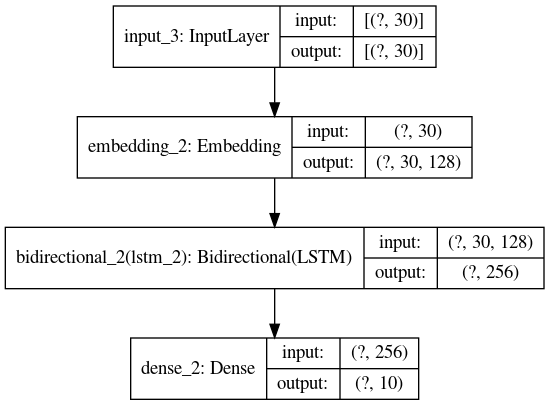

In [54]:
from tensorflow.keras.utils import plot_model
plot_model(model, 'model.png', show_shapes=True)

In [55]:
pred.shape

(30, 10)

In [67]:
y.iloc[700]

'Education'

In [70]:
model.save('model.h5')